<a href="https://colab.research.google.com/github/Paradorn657/recurrent_nearal/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sequence - vector RNN**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
   # รับ series มา จัดกลุ่ม 30 และ 31 คือ ลาเบล ในทุกๆสโคบ
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

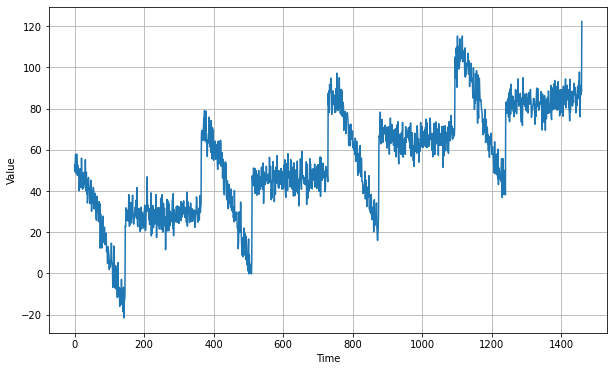

In [33]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
series_train = series[:split_time]

time_valid = time[split_time:]
series_valid = series[split_time:]

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(series_train, window_size, batch_size=128)
valid_set = window_dataset(series_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]), # train_set มันมี 2 มิติ ต้องเข้า lamda แปลงเป็น 3 เข้า RNN -- input_shape=[None] คือ รับ any length
  keras.layers.SimpleRNN(100, return_sequences=True),# ออกเป็น sequence (ตามลำดับ)
  keras.layers.SimpleRNN(100),# ออกเป็น vector
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0) # ตัวเลขมันน้อยเลยต้องคูณ เพื่อให้คำนวณง่ายๆ
])
model.compile(loss=keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 76ms/step - loss: 103.2320 - mae: 108.0750 - val_loss: 38.8899 - val_mae: 39.3284
Epoch 2/500
8/8 [==============================] - 0s 55ms/step - loss: 49.9623 - mae: 51.1376 - val_loss: 11.9685 - val_mae: 12.6767
Epoch 3/500
8/8 [==============================] - 0s 52ms/step - loss: 25.0629 - mae: 26.1031 - val_loss: 6.7043 - val_mae: 7.1407
Epoch 4/500
8/8 [==============================] - 0s 41ms/step - loss: 14.5322 - mae: 15.0351 - val_loss: 6.0986 - val_mae: 6.4764
Epoch 5/500
8/8 [==============================] - 0s 51ms/step - loss: 8.2439 - mae: 8.8329 - val_loss: 6.0479 - val_mae: 6.5592
Epoch 6/500
8/8 [==============================] - 0s 45ms/step - loss: 6.1551 - mae: 6.5724 - val_loss: 5.0440 - val_mae: 5.5091
Epoch 7/500
8/8 [==============================] - 0s 48ms/step - loss: 5.7328 - mae: 6.1908 - val_loss: 5.0513 - val_mae: 5.6796
Epoch 8/500
8/8 [==============================] - 0s 38ms/step - loss: 6.40

In [0]:
  def model_forecast(model, series, window_size):
  # รับ series มา จัดกลุ่ม 30 แล้ว predict
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
  

In [0]:
rnn_forecast = model_forecast(model,series[split_time - window_size:-1],window_size)[:, 0]

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
keras.metrics.mean_absolute_error(series_valid, rnn_forecast).numpy()

# **Sequence - Sequence RNN**

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(series_train, window_size,batch_size=128)
valid_set = window_dataset(series_valid, window_size,batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),                               
  keras.layers.SimpleRNN(100, return_sequences=True,input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
model.compile(loss=keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,validation_data=valid_set,callbacks=[early_stopping])

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
keras.metrics.mean_absolute_error(series_valid, rnn_forecast).numpy()